# Data Preprocessing



# Data Preprocessing

**Author:** John Doe

**Goal:** Prepare dataset for modeling by cleaning, encoding, scaling, splitting, and saving processed data.

**Notebook standards:** PEP8-style code, modular cells, inline explanations, and reproducible plotting

## Objectives

1. Load raw dataset  
2. Clean missing values & outliers  
3. Encode categorical features  
4. Scale numerical features  
5. Split into train/test sets  
6. Save processed files  

This notebook is organized into sections: Imports → Utilities → Load Data → Data Overview → Feature Engineering → Encode Categorical Variables → Scaling → Train test split → Summary.


In [1]:
# Standard library imports
import os
from typing import Tuple
import warnings
from IPython.display import display

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

# Constants
DATA_PATH = r"../data/processed/cleaned.xlsx"  # update path if file is located elsewhere


In [21]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load dataset from CSV or Excel file.
    Args:
        path (str): File path of dataset.
    Returns:
        pd.DataFrame: Loaded dataset.
    """
    if path.endswith('.csv'):
        return pd.read_csv(path)
    elif path.endswith('.xlsx'):
        return pd.read_excel(path,engine='openpyxl')
    else:
        raise ValueError('Unsupported file format. Use CSV or XLSX.')



In [22]:
# Load the dataset (update DATA_PATH if necessary)

try:
    df = load_data(DATA_PATH)
    print('Data loaded Successfully.')
    if not df.empty:
        display(df.head())
except Exception as exec:
    print('Data failed to load:', exec)
    df = pd.DataFrame()  # Prevent NameError


Data loaded Successfully.


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


### Feature Engineering

In [23]:
def create_risk_features(data: pd.DataFrame) -> pd.DataFrame:
    """Generate risk scores based on medical history."""
    risk_scores = {
        'diabetes': 6,
        'high blood pressure': 6,
        'no disease': 0,
        'thyroid': 5,
        'heart disease': 8
    }

    data[['disease1', 'disease2']] = data['medical_history'].str.split(' & ', expand=True)
    data = data.fillna({'disease1': np.nan, 'disease2': np.nan})
    data['total_risk'] = 0
    for col in ['disease1', 'disease2']:
        data['total_risk'] += data[col].str.lower().map(risk_scores).fillna(0)


    min_ = data['total_risk'].min()
    max_ = data['total_risk'].max()


    data['normalized_risk'] = data['total_risk'].apply(lambda row : (row - min_)/(max_ - min_))
    
    return data

df = create_risk_features(df)
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk,normalized_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,High blood pressure,NaN,6.0,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,No Disease,NaN,0.0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,No Disease,NaN,0.0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,No Disease,NaN,0.0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,No Disease,NaN,0.0,0.000000


### Feature Selection

In [ ]:
def feature_selection(data: pd.DataFrame,columns: list) -> pd.DataFrame:
    '''
    Droping columns that no longer needed 
    
    '''
    data = data.drop(columns,axis=1)

    return data

df = feature_selection(df,['medical_history','disease1', 'disease2', 'total_risk'])

df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,4,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,Silver,11050,3,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,Silver,11857,4,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,Bronze,5684,2,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,Bronze,5712,1,0.000000


### Encoding

In [25]:
def encoding_cat_vars(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encoding categorical variables:
      - Map ordinal categorical variables to numbers
      - Apply one-hot encoding to nominal categorical variables
    
    Parameters
    ----------
    df : pd.DataFrame
        Input insurance dataframe
    
    Returns
    -------
    pd.DataFrame
        Preprocessed dataframe
    """

    # Make a copy to avoid modifying original
    df = df.copy()

    # Ordinal mappings
    df['insurance_plan'] = df['insurance_plan'].map({
        'Bronze': 1, 
        'Silver': 2, 
        'Gold': 3
    })

    df['income_level'] = df['income_level'].map({
        '<10L': 1, 
        '10L - 25L': 2, 
        '25L - 40L': 3, 
        '> 40L': 4
    })

    # One-hot encoding for nominal categorical columns
    df = pd.get_dummies(
        df,
        columns=['gender','bmi_category','region','marital_status','smoking_status','employment_status'],
        drop_first=True,
        dtype=int
    )

    return df

df =encoding_cat_vars(df)

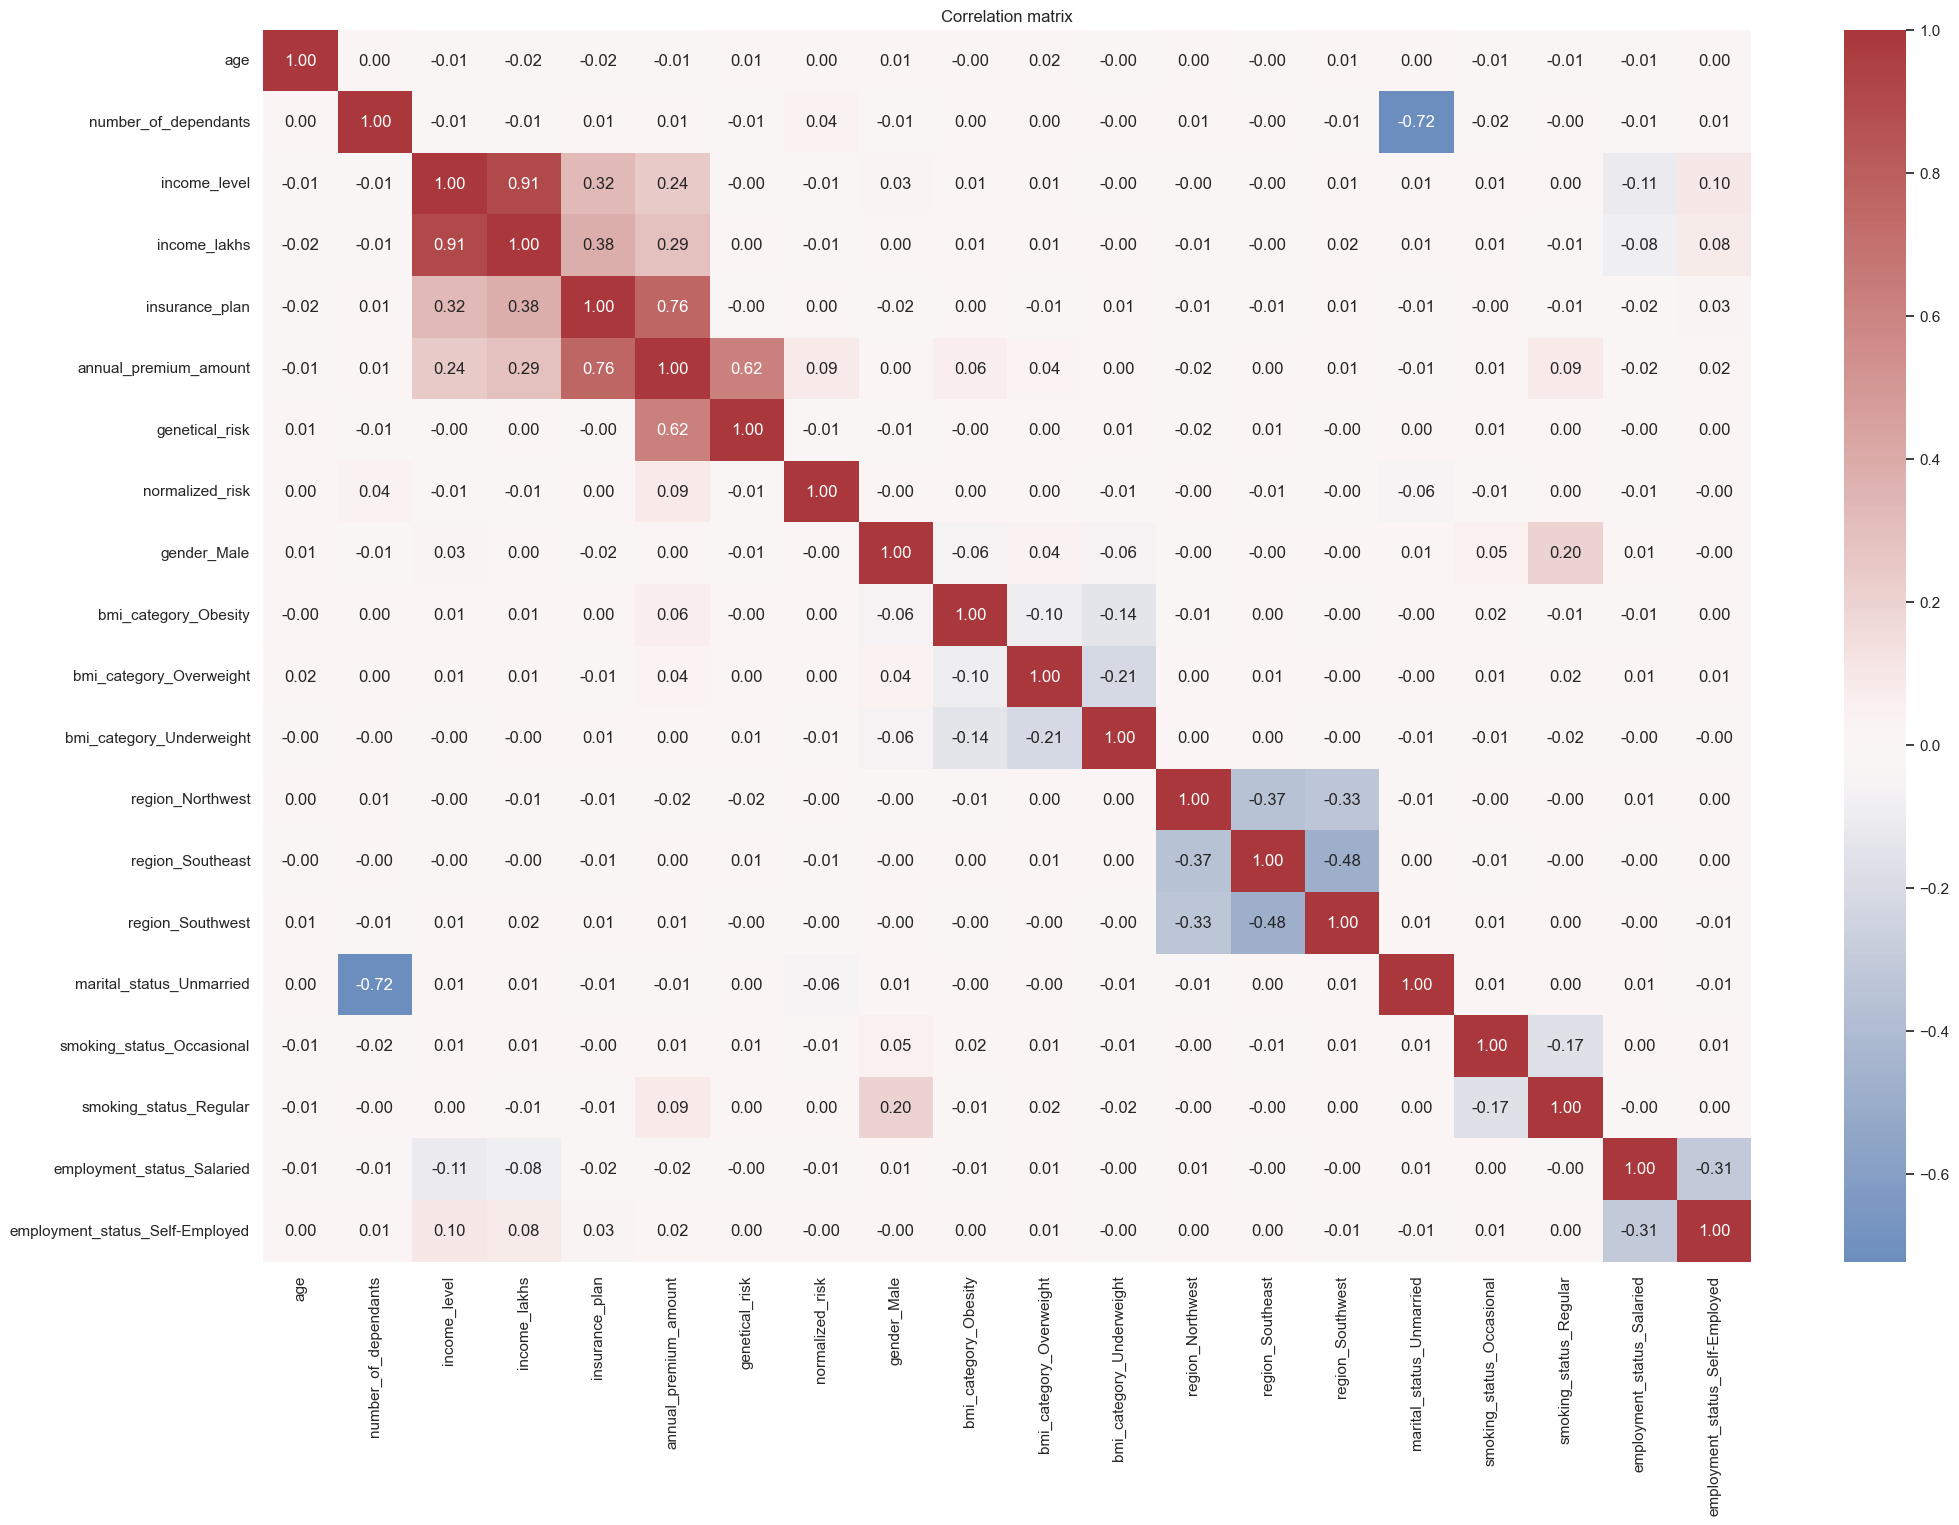

In [26]:
def plot_correlation_matrix(df: pd.DataFrame, numeric_only: bool = True,figsize: Tuple[int, int] = (24, 16)): 
    #num_df = df.select_dtypes() if numeric_only else df.copy()
    corr = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap='vlag', center=0,fmt='.2f')
    plt.title('Correlation matrix')
    plt.show()

plot_correlation_matrix(df)

### Feature scaling

In [27]:
def scale_features(df: pd.DataFrame, target_col: str, cols_to_scale: list) -> tuple:
    """
    Split dataset into X and y, and apply MinMax scaling to selected columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        The target column to predict
    cols_to_scale : list
        List of feature columns to scale
    
    Returns
    -------
    X : pd.DataFrame
        Features dataframe with scaled selected columns
    y : pd.Series
        Target variable
    scaler : MinMaxScaler
        Fitted scaler (useful for transforming new/unseen data)
    """
    
    # Separate features and target
    X = df.drop(target_col, axis=1).copy()
    y = df[target_col].copy()

    # Initialize and fit scaler
    scaler = MinMaxScaler()
    X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

    return X, y, scaler





### Variance Inflation Factor

In [28]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate Variance Inflation Factor (VIF) for each feature in a DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing only the features (no target column).
    
    Returns
    -------
    pd.DataFrame
        DataFrame with two columns:
        - 'Feature': feature names
        - 'VIF': variance inflation factor values
    """
    # Ensure only numeric columns are used
    numeric_df = df.select_dtypes(include=['int64', 'float64']).copy()

    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_df.columns
    vif_data['VIF'] = [
        variance_inflation_factor(numeric_df.values, i)
        for i in range(numeric_df.shape[1])
    ]

    return vif_data


In [ ]:
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']

X, y, scaler = scale_features(df, target_col='annual_premium_amount', cols_to_scale=cols_to_scale) 

In [29]:
vif_results = calculate_vif(X)
vif_results

,Feature,VIF
0,age,2.274875
1,number_of_dependants,1.469601
2,income_level,11.620247
3,income_lakhs,11.815231
4,insurance_plan,1.579278
5,genetical_risk,2.229421
6,normalized_risk,1.140461


In [30]:
vif_results = calculate_vif(X.drop('income_level',axis=1))
vif_results

,Feature,VIF
0,age,2.252941
1,number_of_dependants,1.467671
2,income_lakhs,2.076996
3,insurance_plan,1.575472
4,genetical_risk,2.219159
5,normalized_risk,1.140011


## Train-Test Split & Save Processed Data

In [35]:
def split_and_save_data(X: pd.DataFrame, y: pd.Series, scaler,
                        output_dir: str = '../data/processed/',
                        test_size: float = 0.2, random_state: int = 42):
    """
    Split dataset into train/test sets and save them along with scaler.
    """

 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
 
    os.makedirs(output_dir, exist_ok=True)
    X_train.to_csv(os.path.join(output_dir, 'X_train.csv'), index=False)
    X_test.to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
    y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False)
    y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False)
 
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
 
    print('✅ Data split and saved successfully.')
    return X_train, X_test, y_train, y_test


In [ ]:

X_train, X_test, y_train, y_test = split_and_save_data(X, y, scaler)

✅ Data split and saved successfully.


## Summary

- ✅ Loaded cleaned dataset  
- ✅ Engineered risk features  
- ✅ Encoded categorical variables  
- ✅ Scaled numerical features  
- ✅ Checked multicollinearity (VIF)  
- ✅ Split into train/test sets  
- ✅ Saved all processed files  

